# Final Figures

## Imports

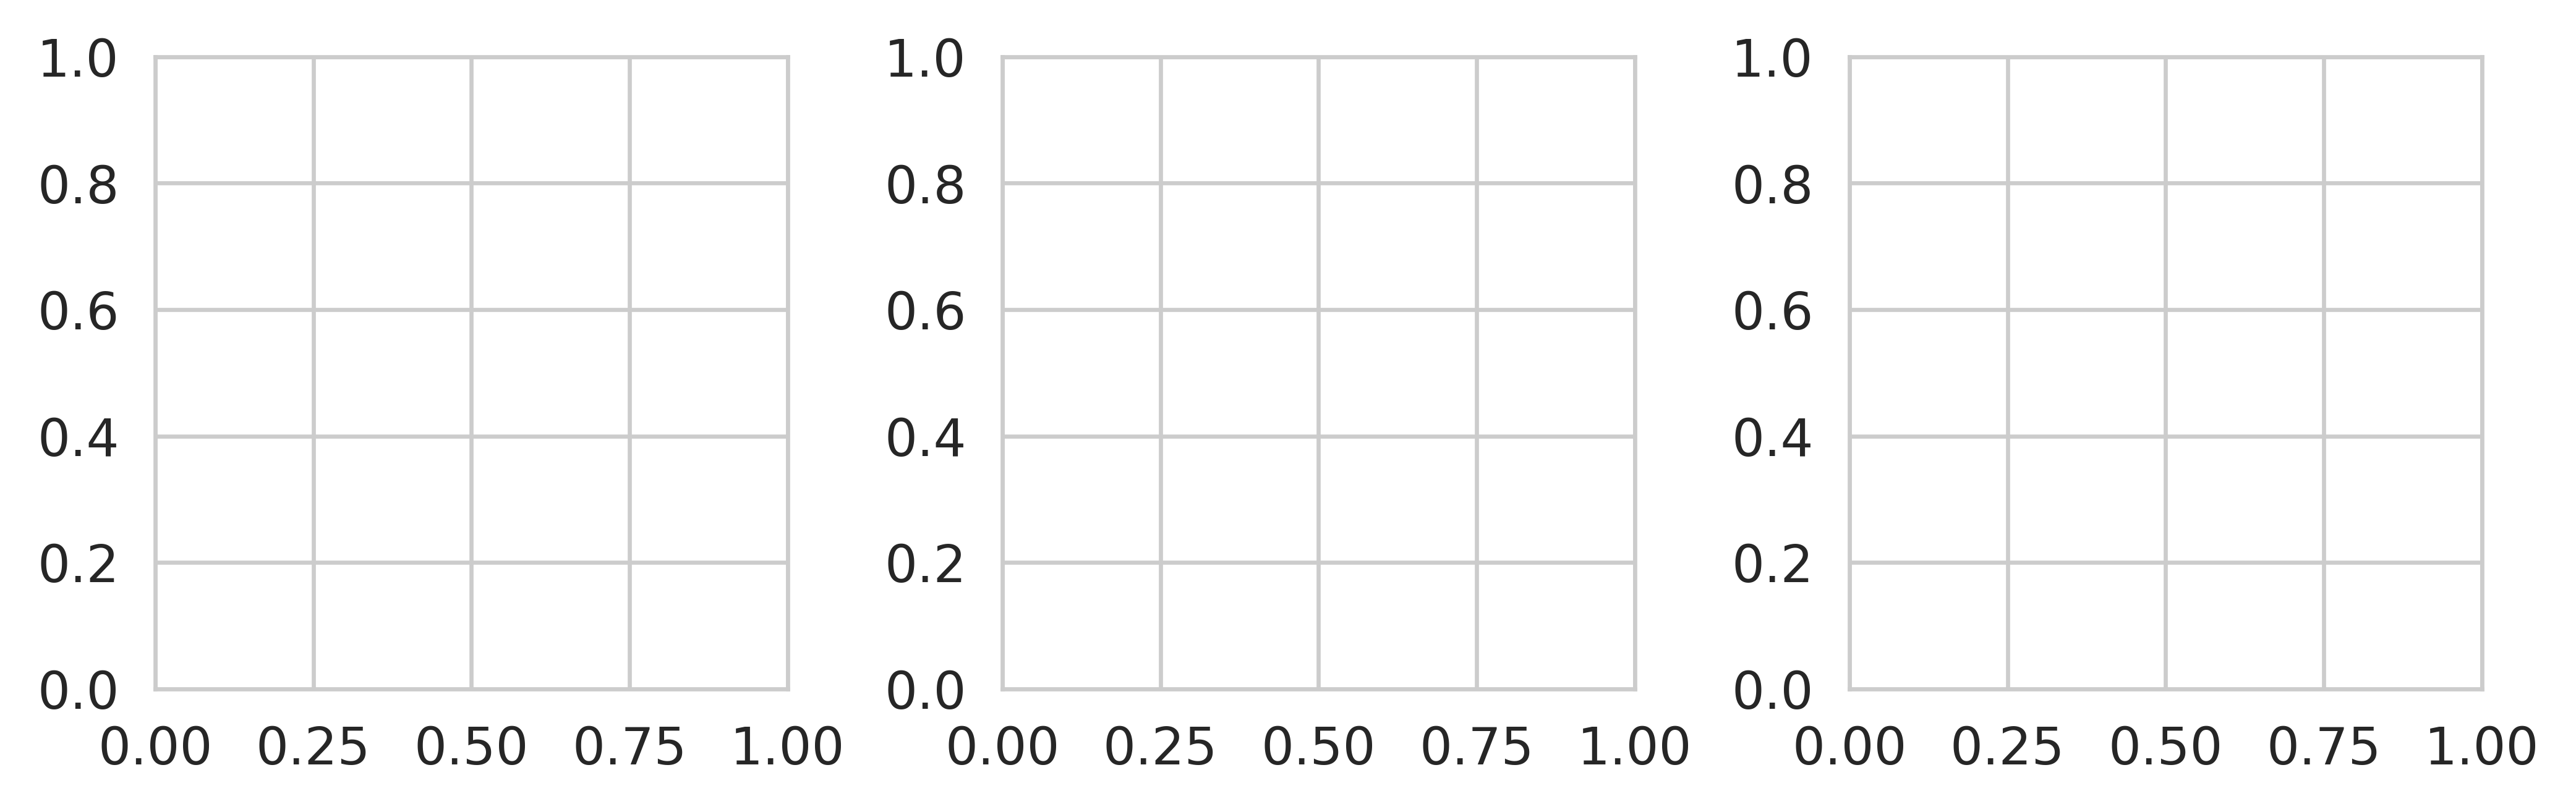

In [ ]:
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)

fig1 = plt.figure(figsize=(7, 6.6), dpi=600, facecolor="None")

gs1 = GridSpec(1, 3, fig1)

ax000 = fig1.add_subplot(gs1[0, 0])
ax001 = fig1.add_subplot(gs1[0, 1])
ax002 = fig1.add_subplot(gs1[0, 2])

ax000.set_aspect("equal")
ax001.set_aspect("equal")
ax002.set_aspect("equal")

fig1.tight_layout()

## Figure 1

In [1]:
import pandas as pd
from scipy import stats
from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from Checkpoints import Checkpoint

##### Fig1 #####
sns.set_style("whitegrid")
sns.set_palette("Blues")

fig1 = plt.figure(figsize=(14, 7), dpi=600)
fig1.supxlabel("Modification per CpG (%)", y=0.2)
# fig1.supylabel("Modification per CpG (%)")

gs1 = GridSpec(1, 3, fig1)

##### ax000 ##### 

ax000 = fig1.add_subplot(gs1[0, 0])

if not "two_mod_wide" in locals():
    two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()

ax000.set_aspect("equal")
div0 = make_axes_locatable(ax000)
cax0 = div0.append_axes("right", size="5%", pad=0.05)
sns.histplot(two_mod_wide, x="percentMeth_WGBS", y="percentMeth_Nanopore", 
             bins=20, pthresh=0.01, stat="density", cbar=True, cbar_kws={"label" : "Density"}, cbar_ax=cax0, ax=ax000)

# ax000.text(50, 105, "r={r:.2f}".format(r=stats.pearsonr(two_mod_wide["percentMeth_WGBS"], two_mod_wide["percentMeth_Nanopore"]).correlation), ha="center")
ax000.set_xlim((0, 100))
ax000.set_ylim((0, 100))
ax000.set_xlabel("WGBS 5modC (%)")
ax000.set_ylabel("Nanopore 5modC (%)")
ax000.set_title("A", loc="left")
ax000.xaxis.set_major_locator(MultipleLocator(25))

##### ax001 ##### 

ax001 = fig1.add_subplot(gs1[0, 1])

if not "mc_df_wide" in locals():
    mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()

ax001.set_aspect("equal")
div1 = make_axes_locatable(ax001)
cax1 = div1.append_axes("right", size="5%", pad=0.05)
sns.histplot(mc_df_wide, x="percentMeth_oxBS_5mC", y="percentMeth_Nanopore_5mC", 
             bins=20, pthresh=0.01, stat="density", cbar=True, cbar_kws={"label" : "Density"}, cbar_ax=cax1, ax=ax001)

# ax001.text(50, 105, "r={r:.2f}".format(r=stats.pearsonr(mc_df_wide["percentMeth_oxBS_5mC"], mc_df_wide["percentMeth_Nanopore_5mC"]).correlation), ha="center")
ax001.set_xlim((0, 100))
ax001.set_ylim((0, 100))
ax001.set_xlabel("oxBS 5mC (%)")
ax001.set_ylabel("Nanopore 5mC (%)")
ax001.set_title("B", loc="left")
ax001.xaxis.set_major_locator(MultipleLocator(25))

##### ax002 ##### 

hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

ax002 = fig1.add_subplot(gs1[0, 2])

ax002.set_aspect("equal")
div2 = make_axes_locatable(ax002)
cax2 = div2.append_axes("right", size="5%", pad=0.05)
sns.histplot(hmc_df_wide, x="percentMeth_TAB_5hmC", y="percentMeth_Nanopore_5hmC", 
             bins=20, pthresh=0.01, stat="density", cbar=True, cbar_kws={"label" : "Density"}, cbar_ax=cax2, ax=ax002)

# ax002.text(50, 105, "r={r:.2f}".format(r=stats.pearsonr(hmc_df_wide["percentMeth_TAB_5hmC"], hmc_df_wide["percentMeth_Nanopore_5hmC"]).correlation), ha="center")
ax002.set_xlim((0, 100))
ax002.set_ylim((0, 100))
ax002.set_xlabel("TAB 5hmC (%)")
ax002.set_ylabel("Nanopore 5hmC (%)")
ax002.set_title("C", loc="left")
ax002.xaxis.set_major_locator(MultipleLocator(25))

fig1.tight_layout()
fig1.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure1.png', bbox_inches="tight")
plt.close()


(<Axes: >, <Axes: >)

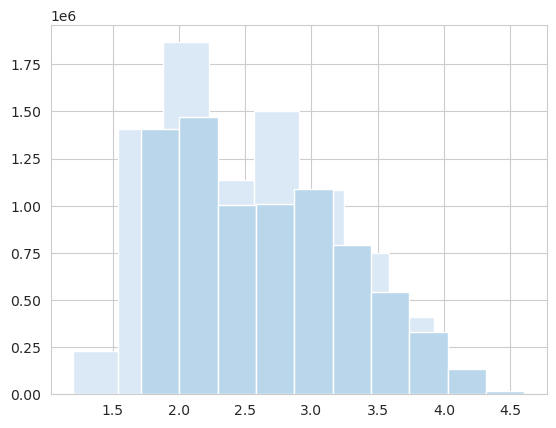

In [15]:
import numpy as np

a = hmc_df_wide["percentMeth_Nanopore_5hmC"]
b = hmc_df_wide["percentMeth_TAB_5hmC"]

with np.errstate(divide="ignore"):
    x = np.log(a).replace([-np.inf, np.inf], np.nan)
    y = np.log(b).replace([-np.inf, np.inf], np.nan)
    a_b = np.subtract(a, b)
    x_y = np.subtract(x, y)

In [86]:
np.subtract(mc_df_wide["percentMeth_oxBS_5mC"], mc_df_wide["percentMeth_Nanopore_5mC"]).sum()/len(mc_df_wide)

1.0928175278503458

In [87]:
def mean_signed_deviation(est, pred):
    msd = np.divide(
        np.subtract(pred, est).sum(), 
        len(est)
    )
    return msd

In [88]:
mean_signed_deviation(two_mod_wide["percentMeth_WGBS"], two_mod_wide["percentMeth_Nanopore"])

-2.591962271736803

In [81]:
metrics.mean_absolute_error(two_mod_wide["percentMeth_WGBS"], two_mod_wide["percentMeth_Nanopore"]), metrics.mean_absolute_error(mc_df_wide["percentMeth_oxBS_5mC"], mc_df_wide["percentMeth_Nanopore_5mC"]), metrics.mean_absolute_error(hmc_df_wide["percentMeth_TAB_5hmC"], hmc_df_wide["percentMeth_Nanopore_5hmC"]), 

(8.54308016362844, 11.885142596252544, 8.617854694663102)

In [83]:
metrics.mean_squared_error(two_mod_wide["percentMeth_WGBS"], two_mod_wide["percentMeth_Nanopore"], squared=False), metrics.mean_squared_error(mc_df_wide["percentMeth_oxBS_5mC"], mc_df_wide["percentMeth_Nanopore_5mC"], squared=False), metrics.mean_squared_error(hmc_df_wide["percentMeth_TAB_5hmC"], hmc_df_wide["percentMeth_Nanopore_5hmC"], squared=False)

(11.794314813567036, 15.706512228967076, 12.243811513173025)

In [74]:
from sklearn import metrics

metrics.mean_squared_error(b, a, squared=False)

12.243811513173025

In [ ]:
##### ax100 ##### 

ax100 = fig1.add_subplot(gs1[1, 0])
if not "two_mod_long" in locals():
    two_mod_long = Checkpoint(path='./intermediates/two_mod_long.tsv').loadCheckpoint().replace("Bisulphite", "WGBS")

sns.ecdfplot(two_mod_long, x="percentMeth", hue="method", legend=True, palette="Paired", ax=ax100)
sns.move_legend(ax100, "upper center", title=None)
ax100.set_ylabel("Proportion of all CpG sites")
ax100.set_xlabel("Per site modification level (%)")
ax100.set_xlim([0, 100])
ax100.set_ylim([0, 1])
ax100.set_title("D", loc="left")
ax100.set_aspect(100)

##### ax101 ##### 

ax101 = fig1.add_subplot(gs1[1, 1])
if not "mc_df_long" in locals():
    mc_df_long = Checkpoint(path='./intermediates/mc_df_long.tsv').loadCheckpoint().replace(["Bisulphite", "Nanopore"], ["oxBS", "Nanopore 5mC"])

sns.ecdfplot(mc_df_long, x="percentMeth", hue="method", legend=True, palette="Paired", ax=ax101)
sns.move_legend(ax101, "upper center", title=None)
ax101.set_ylabel("Proportion of all CpG sites")
ax101.set_xlabel("Per site 5mC level (%)")
ax101.set_xlim([0, 100])
ax101.set_ylim([0, 1])
ax101.set_title("E", loc="left")
ax101.set_aspect(100)


Comparison of modified base calls between nanopore sequencing and bisulphite techniques for (A, C) all modified bases and (B, D) 5mC. (A) General modified base detection is highly correlated with whole genome bisulphite (r = 0.93; p < 0.001). (B) Base-level 5mC calls correlate less strongly with oxBS (r = 0.81; p < 0.001). (C-D) Overall modified base detection rates are highly similar. 

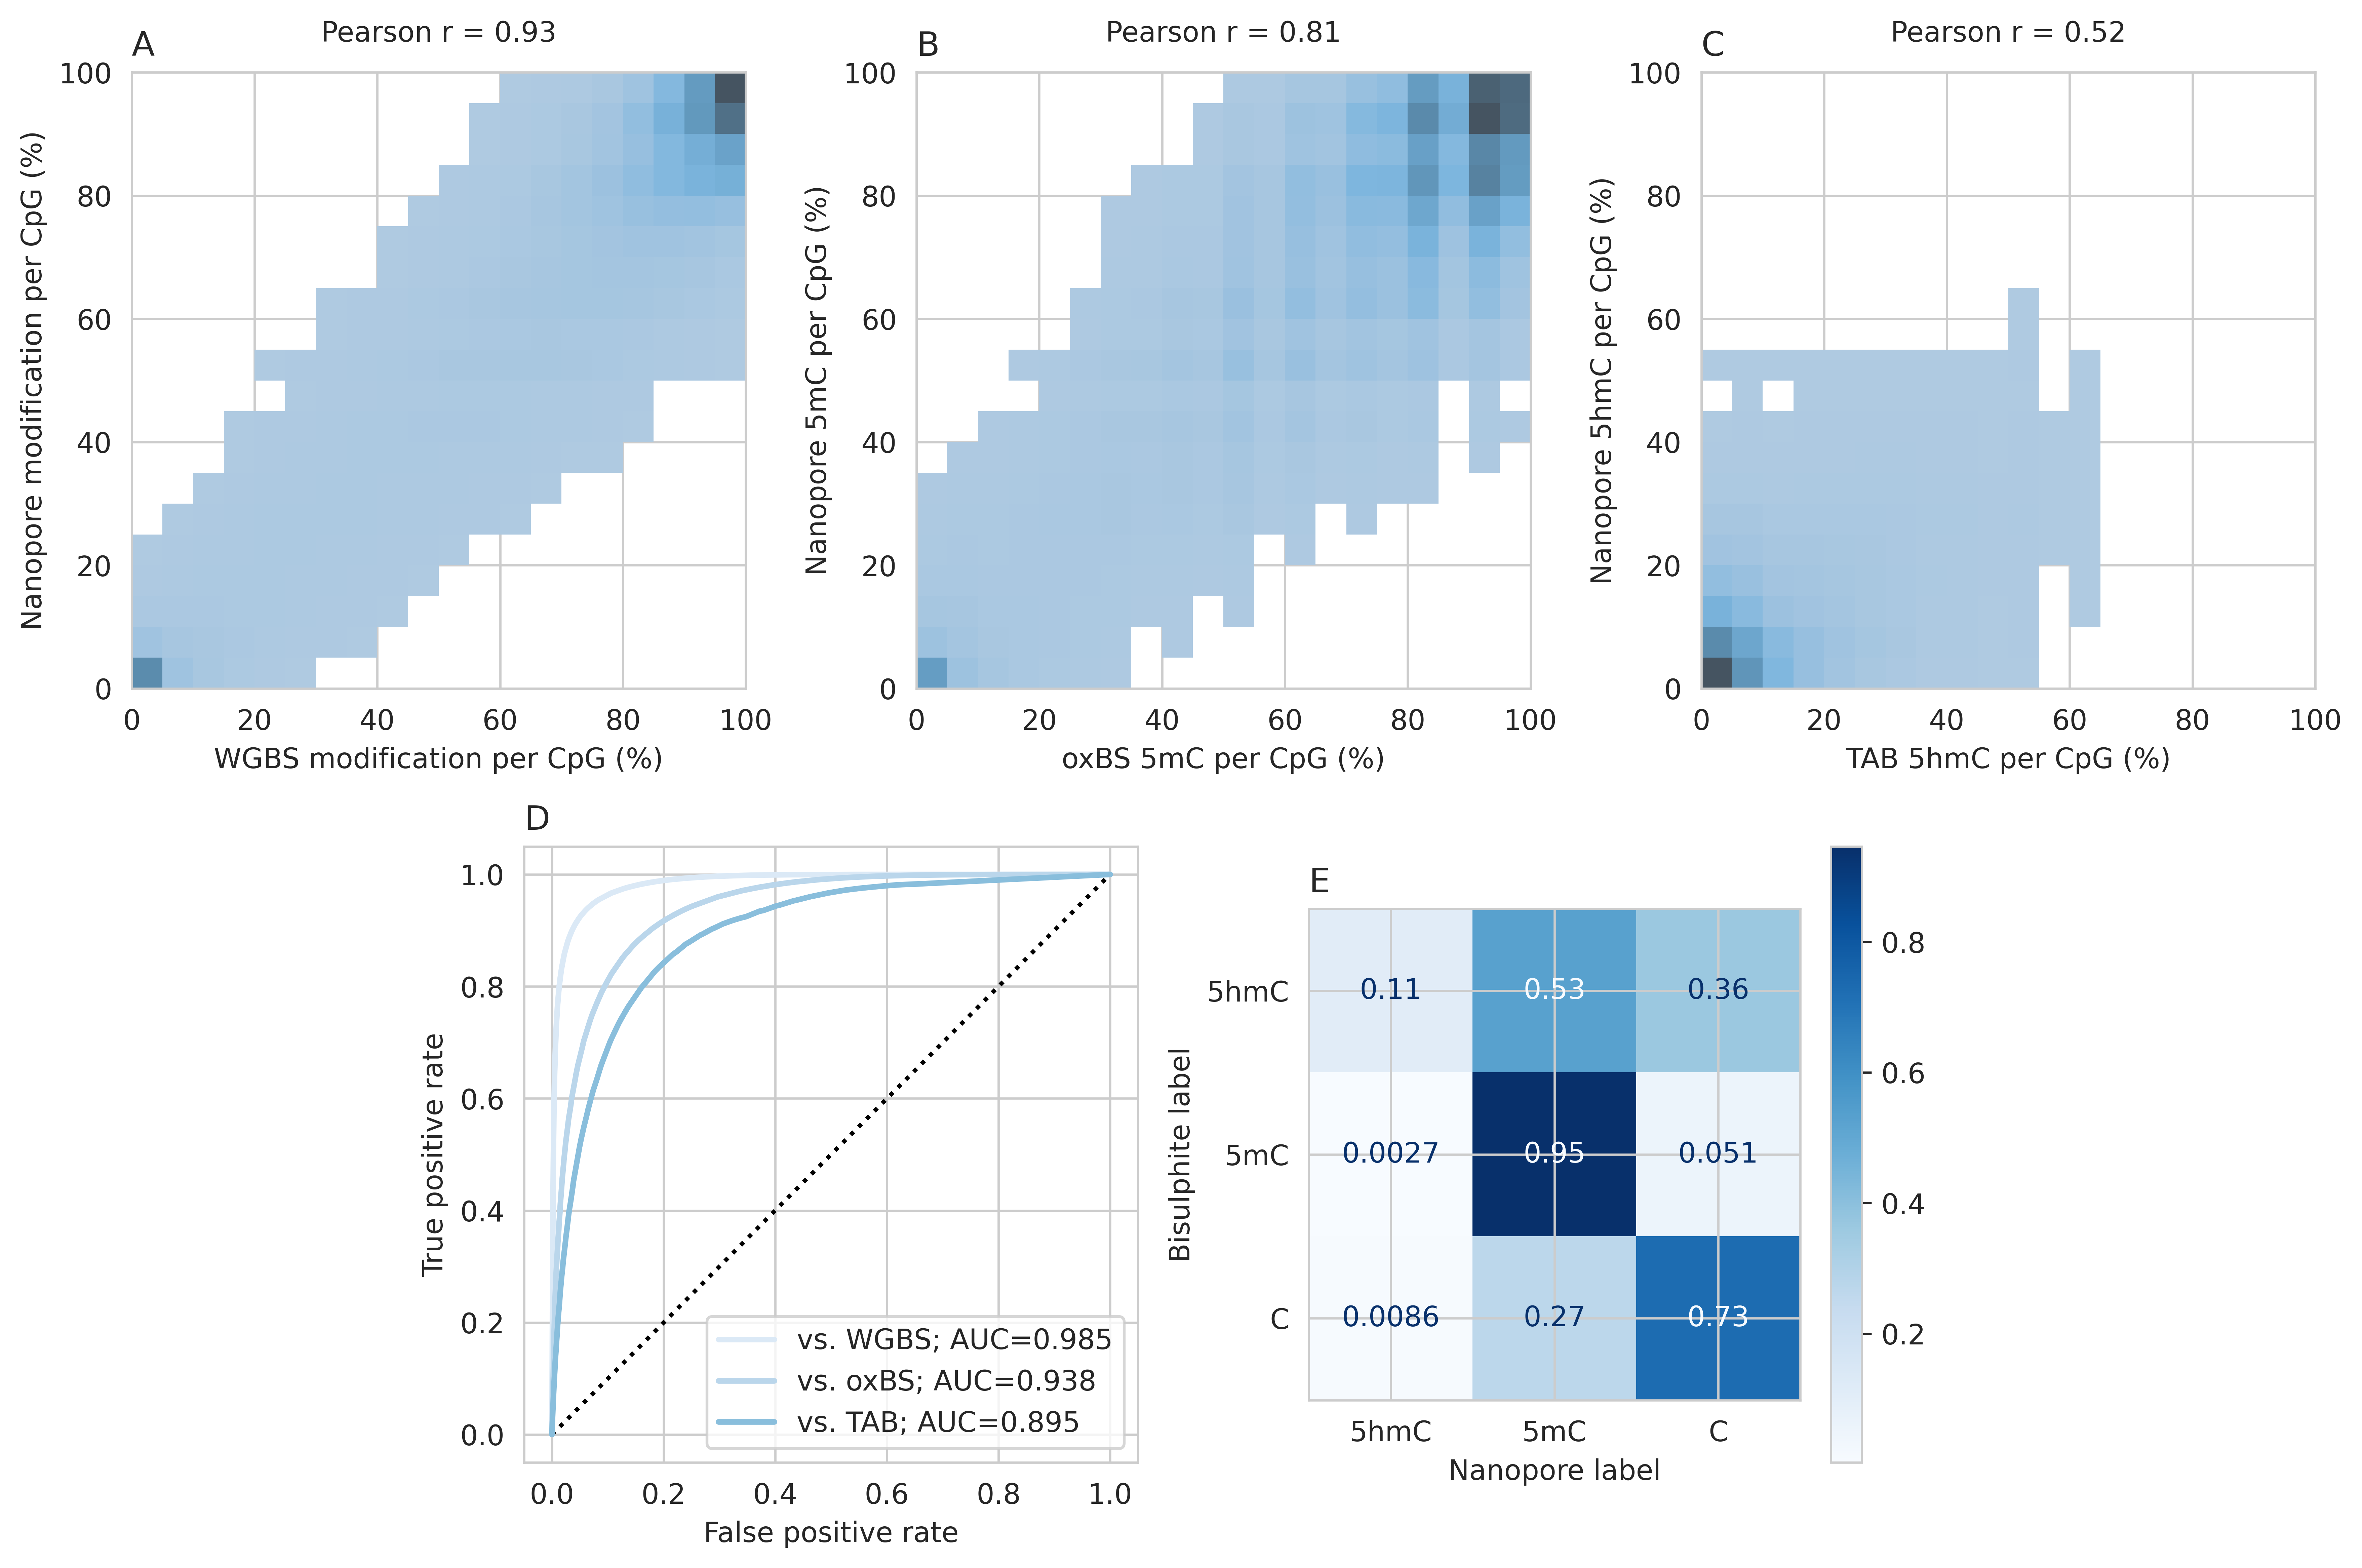

In [28]:
##### Fig1 #####
sns.set_style("whitegrid")
sns.set_palette("Blues")

fig1 = plt.figure(figsize=((30)/2.54, (20)/2.54), dpi=600, facecolor="None")
gs1 = GridSpec(2, 6, fig1)

##### ax100 ##### 

ax100 = fig1.add_subplot(gs1[0, :2])

two_mod_wide = Checkpoint(path="./intermediates/two_mod_wide.tsv").loadCheckpoint()

sns.histplot(two_mod_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax100)
ax100.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(two_mod_wide)[0]), ha="center")
ax100.set_xlim((0, 100))
ax100.set_ylim((0, 100))
ax100.set_xlabel("WGBS modification per CpG (%)")
ax100.set_ylabel("Nanopore modification per CpG (%)")
ax100.set_title("A", loc="left")

##### ax101 ##### 

ax101 = fig1.add_subplot(gs1[0, 2:4])

mc_df_wide = Checkpoint(path="./intermediates/mc_df_wide.tsv").loadCheckpoint()

sns.histplot(mc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax101)
ax101.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(mc_df_wide)[0]), ha="center")
ax101.set_xlim((0, 100))
ax101.set_ylim((0, 100))
ax101.set_xlabel("oxBS 5mC per CpG (%)")
ax101.set_ylabel("Nanopore 5mC per CpG (%)")
ax101.set_title("B", loc="left")

##### ax102 ##### 

ax102 = fig1.add_subplot(gs1[0, 4:])

hmc_df_wide = Checkpoint(path="./intermediates/hmc_df_wide.tsv").loadCheckpoint()

sns.histplot(hmc_df_wide, x="percentMeth_Bisulphite", y="percentMeth_Nanopore", bins=20, pthresh=0.01, stat="density", ax=ax102)
ax102.text(50, 105, "Pearson r = {r:.2f}".format(r=calcPearson(hmc_df_wide)[0]), ha="center")
ax102.set_xlim((0, 100))
ax102.set_ylim((0, 100))
ax102.set_xlabel("TAB 5hmC per CpG (%)")
ax102.set_ylabel("Nanopore 5hmC per CpG (%)")
ax102.set_title("C", loc="left")

##### ax110 ##### 

ax110 = fig1.add_subplot(gs1[1, 1:3])
ax110.plot(np.arange(0, 1.1, 0.1), np.arange(0, 1.1, 0.1), "black", linestyle=":")

ROCPlot(two_mod_wide).plotROC(ax110, "vs. WGBS; AUC={AUC:.3f}".format(AUC=ROCPlot(two_mod_wide).calculateAUC()))
ROCPlot(mc_df_wide).plotROC(ax110, "vs. oxBS; AUC={AUC:.3f}".format(AUC=ROCPlot(mc_df_wide).calculateAUC()))
ROCPlot(hmc_df_wide).plotROC(ax110, "vs. TAB; AUC={AUC:.3f}".format(AUC=ROCPlot(hmc_df_wide).calculateAUC()))

ax110.set_xlabel("False positive rate")
ax110.set_ylabel("True positive rate")
ax110.legend()
sns.move_legend(ax110, "lower right")
ax110.set_title("D", loc="left")

##### ax111 ##### 

ax111 = fig1.add_subplot(gs1[1, 3:5])
ConfusionMatrixDisplay.from_predictions(defineTruthset(), definePredictions(), normalize="true", cmap="Blues", ax=ax111)
ax111.set_xlabel("Nanopore label")
ax111.set_ylabel("Bisulphite label")
ax111.set_title("E", loc="left")

fig1.set_tight_layout(True)
fig1.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure1.png')
fig1.show()

## Figure 2

NameError: name 'featureAndGene' is not defined

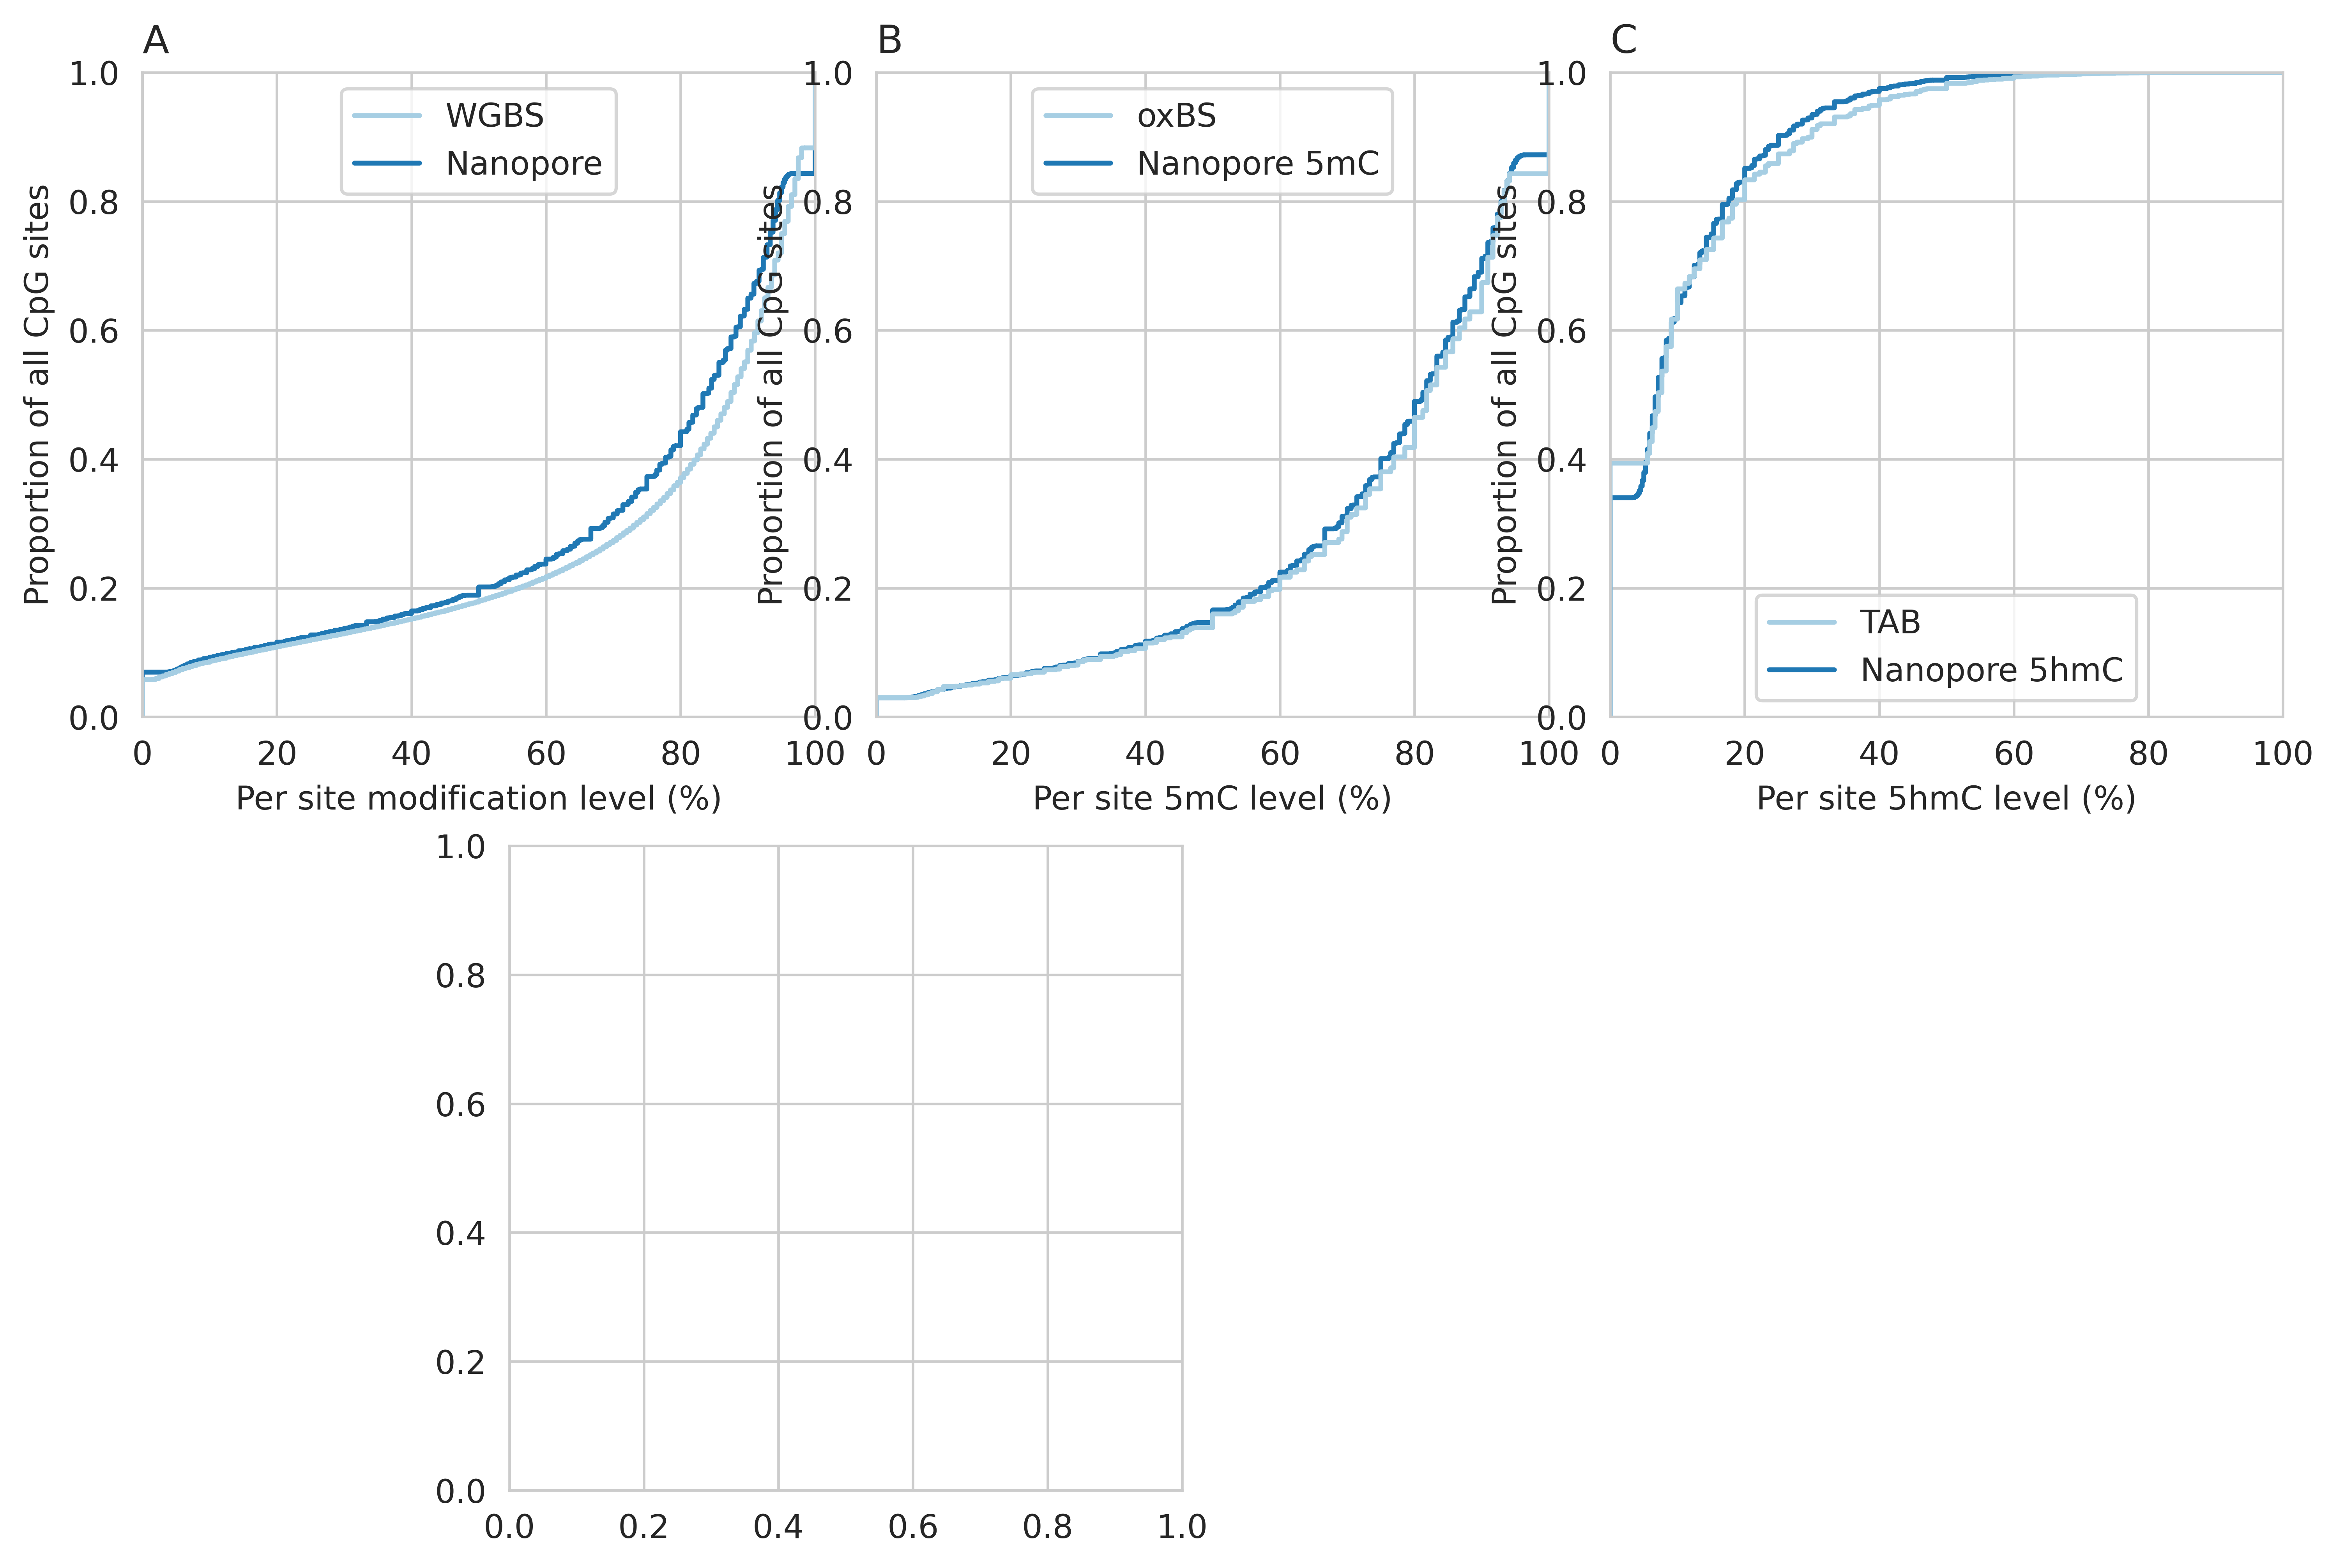

In [7]:
##### Figure 2 #####
sns.set_style("whitegrid")
sns.set_palette("Blues")

fig2 = plt.figure(figsize=((30)/2.54, (20)/2.54), dpi=600, facecolor="None")
gs2 = GridSpec(2, 6, fig2)

##### ax100 ##### 

ax200 = fig2.add_subplot(gs2[0, :2])

sns.ecdfplot(Checkpoint(path='./intermediates/two_mod_long.tsv').loadCheckpoint().replace("Bisulphite", "WGBS"), 
             x="percentMeth", hue="method", legend=True, palette="Paired", ax=ax200)
sns.move_legend(ax200, "upper center", title=None)
ax200.set_ylabel("Proportion of all CpG sites")
ax200.set_xlabel("Per site modification level (%)")
ax200.set_xlim([0, 100])
ax200.set_ylim([0, 1])
ax200.set_title("A", loc="left")

##### ax201 ##### 

ax201 = fig2.add_subplot(gs2[0, 2:4])

sns.ecdfplot(Checkpoint(path='./intermediates/mc_df_long.tsv').loadCheckpoint().replace(["Bisulphite", "Nanopore"], ["oxBS", "Nanopore 5mC"]), 
             x="percentMeth", hue="method", legend=True, palette="Paired", ax=ax201)
sns.move_legend(ax201, "upper center", title=None)
ax201.set_ylabel("Proportion of all CpG sites")
ax201.set_xlabel("Per site 5mC level (%)")
ax201.set_xlim([0, 100])
ax201.set_ylim([0, 1])
ax201.set_title("B", loc="left")

##### ax202 ##### 

ax202 = fig2.add_subplot(gs2[0, 4:])

sns.ecdfplot(Checkpoint(path='./intermediates/hmc_df_long.tsv').loadCheckpoint().replace(["Bisulphite", "Nanopore"], ["TAB", "Nanopore 5hmC"]), 
             x="percentMeth", hue="method", legend=True, palette="Paired", ax=ax202)
sns.move_legend(ax202, "lower center", title=None)
ax202.set_ylabel("Proportion of all CpG sites")
ax202.set_xlabel("Per site 5hmC level (%)")
ax202.set_xlim([0, 100])
ax202.set_ylim([0, 1])
ax202.set_title("C", loc="left")

##### Histogram shared #####

data = Checkpoint(path='./intermediates/three_mod_pyrange.tsv').loadCheckpoint()

##### ax220 #####

ax220 = fig2.add_subplot(gs2[1, 1:3])

gene_data = featureAndGene(CpGIntersects(data).group("genes"), 10)

gene_data.makeHist("count", ax220)
ax220.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")

gene_r, gene_p = gene_data.calcPearson()
gene_rho, gene_rhoP = gene_data.calcSpearman()

ax220.text(3-(5.5+3)/2, 3.3, "Pearson r = {r:.2f}".format(r=gene_r), ha="center")
ax220.text(3-(5.5+3)/2, 3.8, "Spearman \u03C1 = {rho:.2f}".format(rho=gene_rho), ha="center")
ax220.set_ylim((-5.5, 3))
ax220.set_xlim((-5.5, 3))
ax220.set_xlabel("TAB enrichment")
ax220.set_ylabel("Nanopore enrichment")
ax220.set_title("D", loc="left")

##### ax221 ##### 

ax221 = fig2.add_subplot(gs2[1, 3:5])

tile_data = tiledGroup(CpGIntersects(data).groupByGenomicWindow(300), 10)

tile_data.makeHist("density", ax=ax221)
ax221.plot(np.arange(-5.5, 4, 1), np.arange(-5.5, 4, 1), color="black", linestyle=":")

tile_r, tile_p = tile_data.calcPearson()
tile_rho, tile_p = tile_data.calcSpearman()

ax221.text(3-(5.5+3)/2, 3.3, "Pearson r = {r:.2f}".format(r=tile_r), ha="center")
ax221.text(3-(5.5+3)/2, 3.8, "Spearman \u03C1 = {rho:.2f}".format(rho=tile_rho), ha="center")
ax221.set_ylim((-5.5, 3))
ax221.set_xlim((-5.5, 3))
ax221.set_xlabel("TAB enrichment")
ax221.set_ylabel("Nanopore enrichment")
ax221.set_title("E", loc="left")

##### Outputs #####

fig2.set_tight_layout(True)
fig2.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure2.png')
fig2.tight_layout()

### Figure 2 Data Table
This data table highlights 300bp regions showing substantial hydroxymethylation in Nanopore or TAB, as well as regions enriched/depleted in both to act as controls. 

In [ ]:
data = Checkpoint(path='./intermediates/three_mod_pyrange.tsv').loadCheckpoint()

In [ ]:
all_tiles = tiledGroup(CpGIntersects(data).groupByGenomicWindow(300), 10)
all_tiles.exportTests(10)

In [ ]:
all_tiles.calcMannWhitney("less")

MannwhitneyuResult(statistic=27822203.0, pvalue=1.200434190068272e-13)

## Figure 3

/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)
/mnt/data1/doh28/tools/condas/GeneralAnalysis/lib/python3.9/site-packages/seaborn/utils.py:482: UserWarning: You have mixed positional and keyword arguments, some input may be discarded.
  new_legend = legend_func(handles, labels, loc=loc, **props)


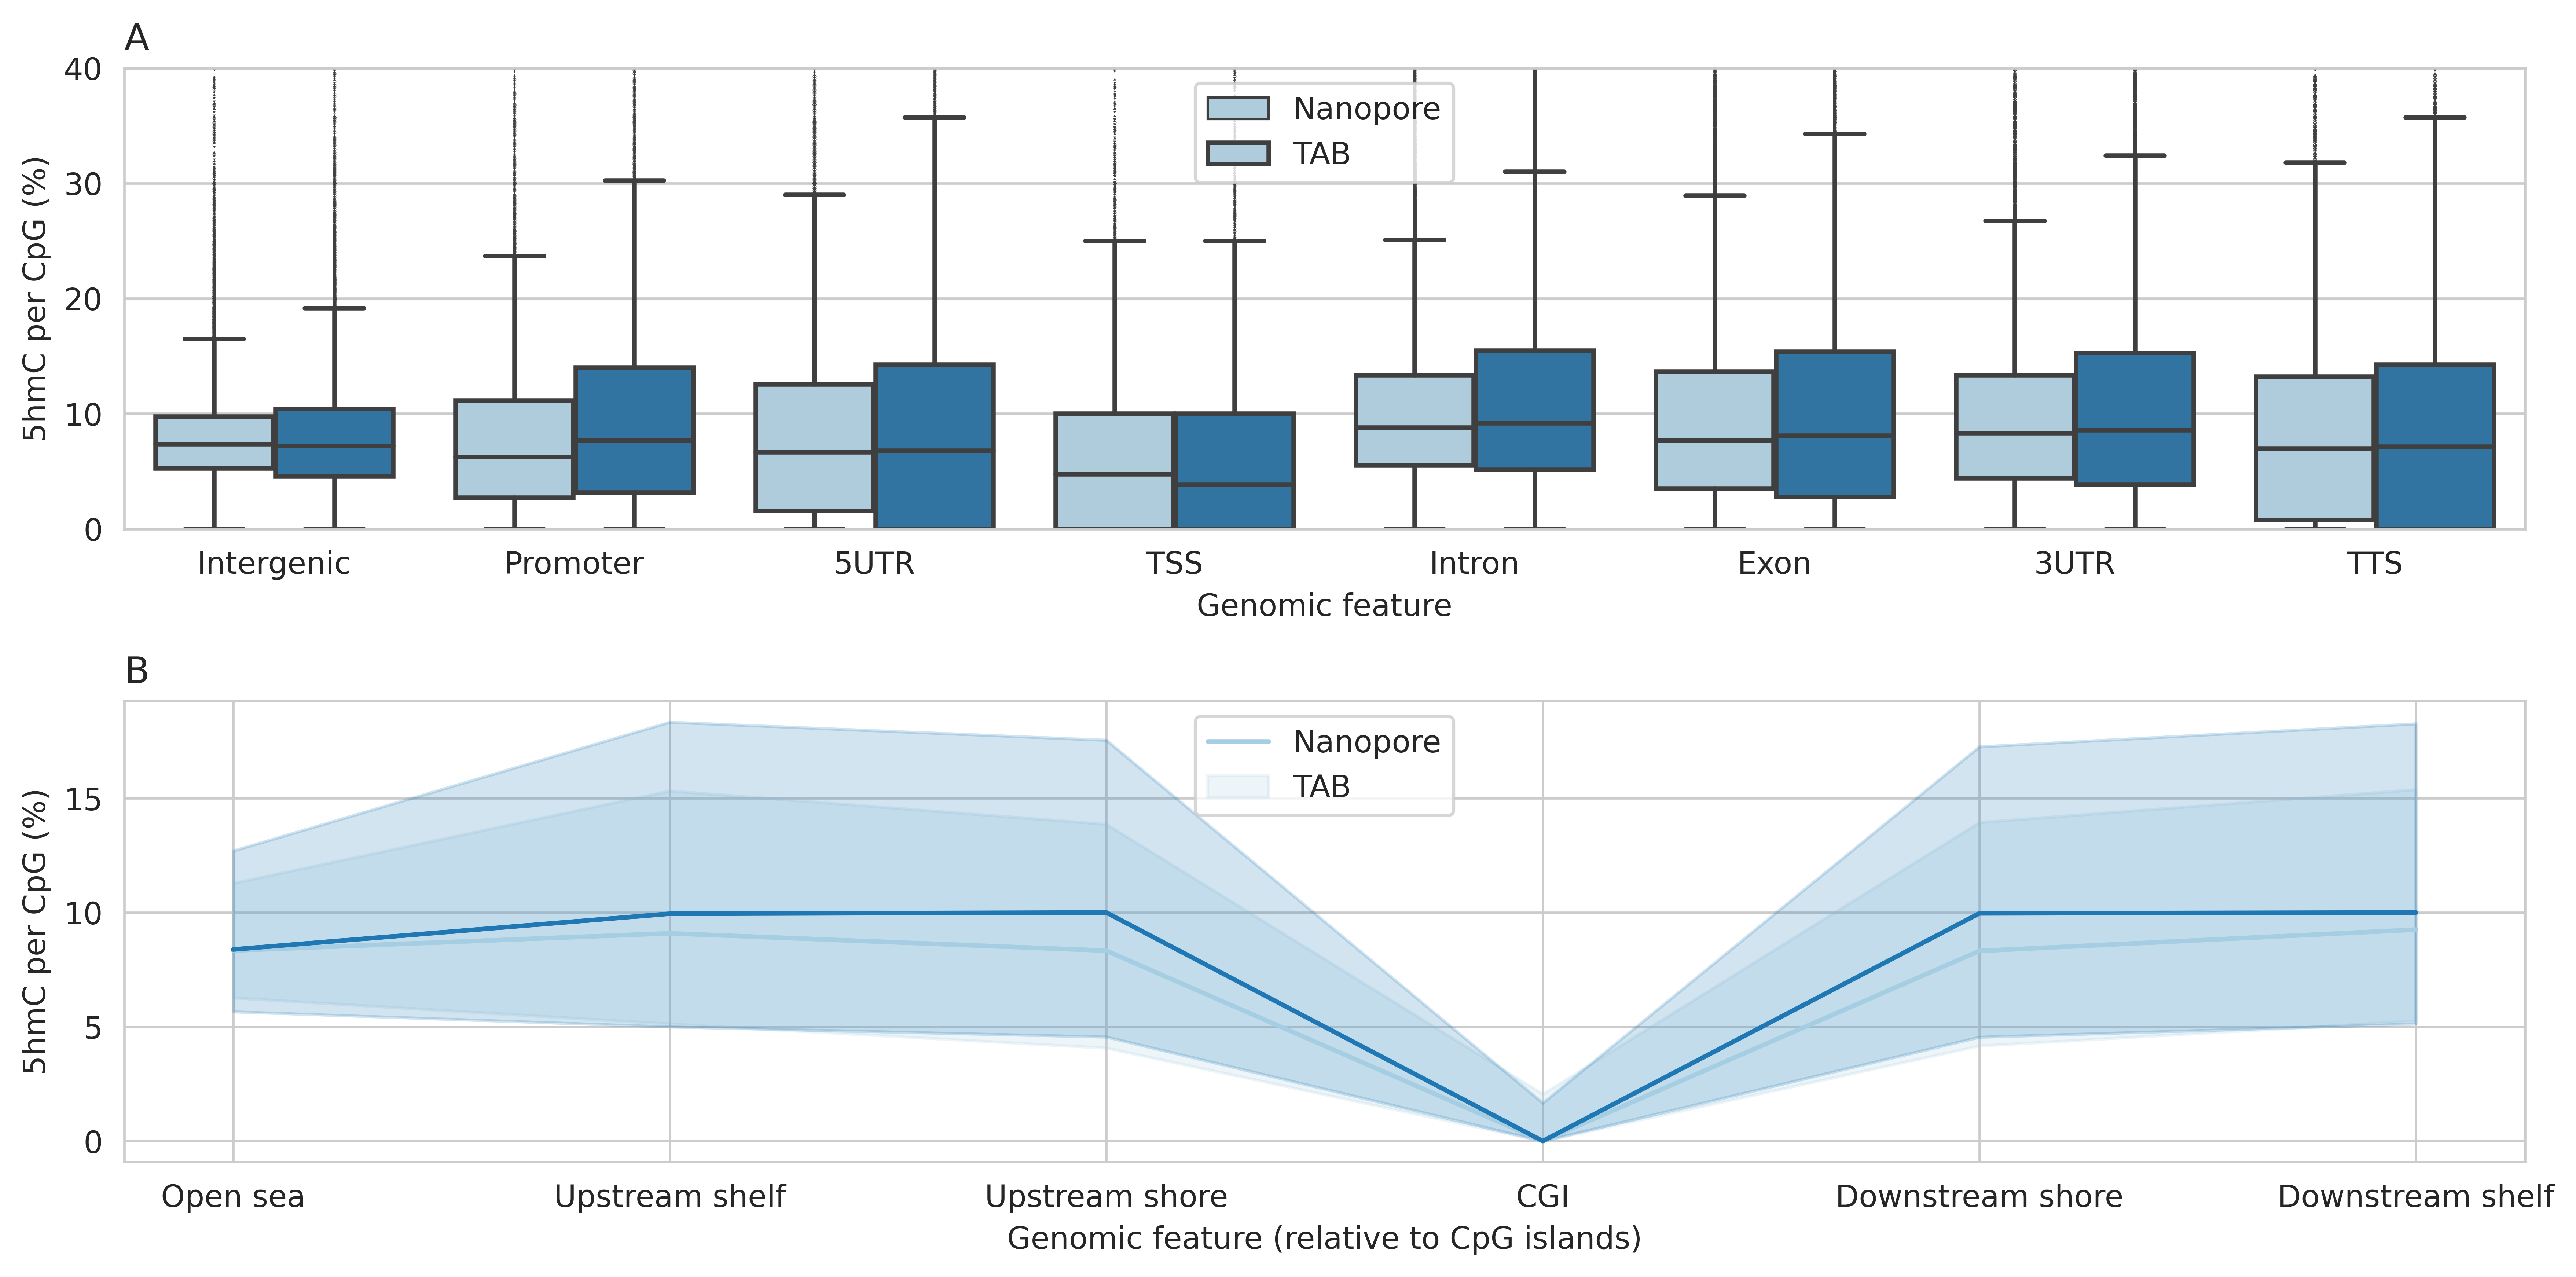

In [88]:
##### Figure 3 #####
sns.set_style("whitegrid")
sns.set_palette("Paired")

fig3 = plt.figure(figsize=((30/2.54), (15/2.54)), dpi=600)
gs3 = GridSpec(2, 1, fig3)

##### ax300 ##### 

ax300 = fig3.add_subplot(gs3[0, 0])

featureAndGene(CpGIntersects(data).group("features")).makeBoxplots(ax300)
sns.move_legend(ax300, "upper center", title=None, labels=["Nanopore", "TAB"])
ax300.set_title("A", loc="left")
ax300.set_ylim((0, 40))
ax300.set_ylabel("5hmC per CpG (%)")
ax300.set_xlabel("Genomic feature")

##### ax300 ##### 

ax310 = fig3.add_subplot(gs3[1, 0])

featureAndGene(CpGIntersects(data).group("CGI")).makeLineplot(ax310)
sns.move_legend(ax310, "upper center", title=None, labels=["Nanopore", "TAB"])
ax310.set_title("B", loc="left")
ax310.set_ylabel("5hmC per CpG (%)")
ax310.set_xlabel("Genomic feature (relative to CpG islands)")

##### Output #####

fig3.set_tight_layout(True)
fig3.savefig('/u/n/doh28/Documents/Nanopore_HMC/Figures/Figure3.png')
fig3.show()